## Statistical Analysis

In [1]:
import pandas as pd
import numpy as np
from pathlib import PurePath
from matplotlib import rc
from utils import filter_df, convert_lists_to_arr, interval_convert, get_features
%load_ext autoreload
%autoreload 2
rc('text', usetex=False) 

PROCESSED_DIR = PurePath("../topolearn/processed_data")
df = pd.read_csv(PROCESSED_DIR / "results.csv")

# Ignored in paper
df = df[df["representation"] != "MolProp2"]

# Process PH diagrams
df[f"dgms"] = convert_lists_to_arr(df[f"dgms"], ragged=True)
df[f"ph_dim_logspace0"] = convert_lists_to_arr(df[f"ph_dim_logspace0"])
df[f"ph_dim_logedges0"] = convert_lists_to_arr(df[f"ph_dim_logedges0"])
df[f"intervals_0"] = df[f"dgms"].apply(interval_convert, args=[0])
df[f"intervals_1"] = df[f"dgms"].apply(interval_convert, args=[1])
df["norm_intervals_0"] = [(i - i.min())/(i.max() - i.min() + 0.0001) if isinstance(i, np.ndarray) else [] for i in df[f"intervals_0"].values]
df["norm_intervals_1"] = [(i - i.min())/(i.max() - i.min() + 0.0001) if isinstance(i, np.ndarray) else [] for i in df[f"intervals_1"].values]

#### Multiple Regression Analysis

- Regress on error while controlling for the various other variables
- The coefficients explain the influence of each variable on the error
- Results explain a moderate amount of the variability, the model is statistically significant overall
- On RMSE the results are even more significant

In [3]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols

filter = {
    "split": "random",
}
subset = filter_df(df, filter)


topo_features, topo_features_tr, contol_features = get_features()
target = "Relative RMSE"

# Stringify variables
model_data = subset[topo_features + contol_features + [target]]
independent_vars = " + ".join(topo_features)
controls = " + ".join([f"C({f})" if f in ["representation_type", "distance_metric"] else f for f in contol_features])
model = ols(f'Q("{target}")  ~ {independent_vars} + {controls}', data=model_data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     Q("Relative RMSE")   R-squared:                       0.455
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                     19.36
Date:                Fri, 21 Feb 2025   Prob (F-statistic):           1.17e-95
Time:                        20:51:52   Log-Likelihood:                 341.65
No. Observations:                 967   AIC:                            -601.3
Df Residuals:                     926   BIC:                            -401.5
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                                 0.4299      0.106      4.068      0.000       0.223       0.637
C(representation_type)[T.embedding]       0.0311      0.025      1.252      0.211      -0.018       0.080
C(representation_type)[T.fingerprint]    -0.1148      0.027     -4.198      0.000      -0.168      -0.061
C(distance_metric)[T.jaccard]            -0.1175      0.028     -4.246      0.000      -0.172      -0.063
b_0                                       0.0002   7.67e-05      2.930      0.003    7.42e-05       0.000
b_1                                    9.898e-05   3.01e-05      3.290      0.001    3.99e-05       0.000
b_0_norm                                 -0.7682      0.178     -4.325      0.000      -1.117      -0.420
b_1_norm                                 -0.2632      0.070     -3.739      0.000      -0.401      -0.125
ph_entr_0                                -0.1027      0.050     -2.068      0.039      -0.200      -0.005
ph_entr_1                                 0.0557      0.032      1.732      0.084      -0.007       0.119
lifetimes_min_0                          -0.0018      0.000     -3.758      0.000      -0.003      -0.001
norm_lifetimes_min_0                      4.4470     20.080      0.221      0.825     -34.961      43.855
lifetimes_max_0                        1.593e-07   3.27e-07      0.488      0.626   -4.82e-07       8e-07
norm_lifetimes_max_0                     -0.5952      0.242     -2.457      0.014      -1.070      -0.120
lifetimes_mean_0                       1.646e-05   1.31e-05      1.256      0.209   -9.25e-06    4.22e-05
norm_lifetimes_mean_0                   -35.3463     17.653     -2.002      0.046     -69.991      -0.702
lifetimes_var_0                          -0.0468      0.028     -1.651      0.099      -0.102       0.009
norm_lifetimes_var_0                     -1.4784      1.451     -1.019      0.309      -4.327       1.370
lifetimes_sum_0                        2.897e-07   2.46e-06      0.118      0.906   -4.54e-06    5.12e-06
norm_lifetimes_sum_0                      0.4315      0.106      4.052      0.000       0.222       0.640
midlifes_min_0                           -0.0009      0.000     -3.758      0.000      -0.001      -0.000
norm_midlifes_min_0                       4.4470     20.080      0.221      0.825     -34.961      43.855
midlifes_max_0                        -8.994e-08   6.43e-07     -0.140      0.889   -1.35e-06    1.17e-06
norm_midlifes_max_0                      -0.5952      0.242     -2.457      0.014      -1.070      -0.120
midlifes_mean_0                        8.248e-06   6.55e-06      1.259      0.208   -4.61e-06    2.11e-05
norm_midlifes_mean_0                    -35.3463     17.653     -2.002      0.046     -69.991      -0.702
midlifes_

#### ANOVA Analysis

In [9]:
anova_table = pd.DataFrame(sm.stats.anova_lm(model, typ=2))
anova_table.sort_values(by="F", ascending=False).head(20)

,sum_sq,df,F,PR(>F)
sari,0.734492,1.0,31.017424,3.385995e-08
twonn_dim,0.558696,1.0,23.593604,1.405158e-06
norm_lifetimes_var_1,0.394774,1.0,16.671212,4.844743e-05
b_0_norm,0.382881,1.0,16.168997,6.284056e-05
b_1,0.360472,1.0,15.222675,1.027417e-04
midlifes_sum_0,0.328239,1.0,13.861463,2.091502e-04
lifetimes_max_0,0.326738,1.0,13.798095,2.162118e-04
lifetimes_sum_0,0.324334,1.0,13.696575,2.280302e-04
norm_lifetimes_min_0,0.315764,1.0,13.334668,2.757312e-04
norm_midlifes_min_0,0.315764,1.0,13.334668,2.757312e-04


#### Correlation analysis

/tmp/ipykernel_1332295/1850227440.py:47: NearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  pval = subset[columns].corr(method=lambda x, y: coeff(x, y)[1]) - np.eye(*rho.shape)


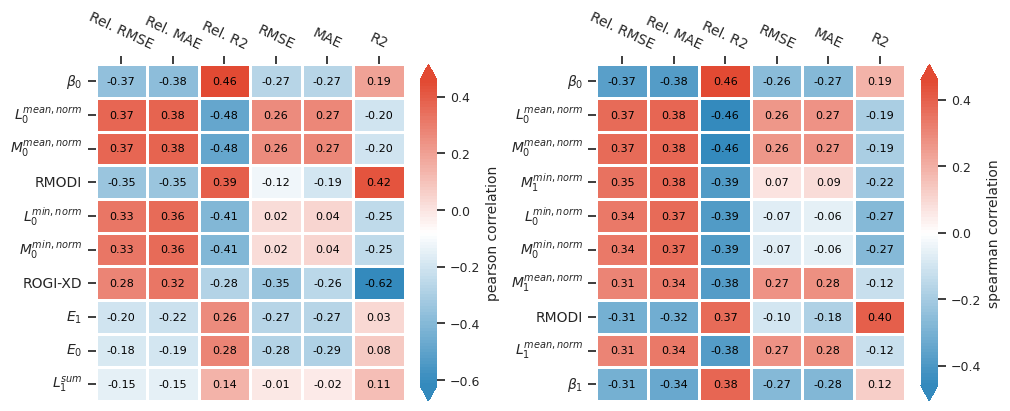

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from plotting import load_plot_config
from utils import get_column_name_mapping
from scipy.stats import pearsonr, spearmanr


def plot_heatmap(data, heat_name, ax):
    palette = sns.blend_palette(["#348ABD", "#FFF", "#E24A33"], n_colors=100)
    cbar_kws = {'extend':'both'} 
    annot_kws={'fontsize': 8,  'color':'black'}
    data_numeric = data.applymap(lambda x: float(x.replace("*", "")))
    
    sns.heatmap(data_numeric, cbar_kws=cbar_kws, annot_kws=annot_kws, cmap=palette, 
                     xticklabels=True, yticklabels=True, annot = True, fmt=".2f", linewidths=1, ax=ax)
    ax.tick_params(axis='x', which='major', labelsize=10, labelbottom = False, bottom=False, top = True, labeltop=True, rotation=-25)
    ax.tick_params(axis='y', which='major', labelsize=10)
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=9)
    cbar.set_label(heat_name, fontsize=10)

def clean_str(x):
    return float(str(x).replace("*", ""))

filter = {
    #"distance_metric": "euclidean",
    #"representation_type": "embedding",
    "split": "random", 
}

subset = filter_df(df, filter)
topo_features, topo_features_tr, contol_features = get_features()
vars = topo_features
targets = ["Relative RMSE", "Relative MAE", "Relative R2", "RMSE", "MAE", "R2"]

load_plot_config()
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.left'] = True
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), constrained_layout=True)
for idx, coeff in enumerate([pearsonr, spearmanr]):
    method = coeff.__name__[:-1]
    columns = vars + targets

    # Compute correlation
    rho = subset[columns].corr(method=method)
    pval = subset[columns].corr(method=lambda x, y: coeff(x, y)[1]) - np.eye(*rho.shape)
    p = pval.applymap(lambda x: ''.join(['*' for t in [.05, .01, .001] if x<=t]))
    corr_tab = rho.round(2).astype(str) + p

    # Sort by baseline and pick top
    corr_tab.drop(targets, axis=0, inplace=True)
    corr_tab = corr_tab[targets]

    # Remove string nans
    corr_tab = corr_tab[~(corr_tab == "nan")].dropna()    
    corr_tab["sort"] = corr_tab["Relative RMSE"].apply(lambda x: abs(clean_str(x)))

    # Plotting
    corr_tab_sub = corr_tab.sort_values(by=f"sort", ascending=False).head(10)
    corr_tab_sub.columns = [c.replace("Relative ", "Rel. ") for c in corr_tab.columns]
    mapping = get_column_name_mapping(df)
    corr_tab_sub.index = pd.Series(corr_tab_sub.index).apply(lambda x: mapping.get(x, x))
    plot_heatmap(corr_tab_sub.drop("sort", axis=1), heat_name=f"{method} correlation", ax=axs[idx])

fig.figure.savefig(f'plots/correlations_{filter["split"]}.png', dpi=300)

#### Plot 1: Correlation Histogram for individual datasets and different sample sizes, metrics, models and scores

100%|██████████| 12/12 [00:00<00:00, 55.22it/s]


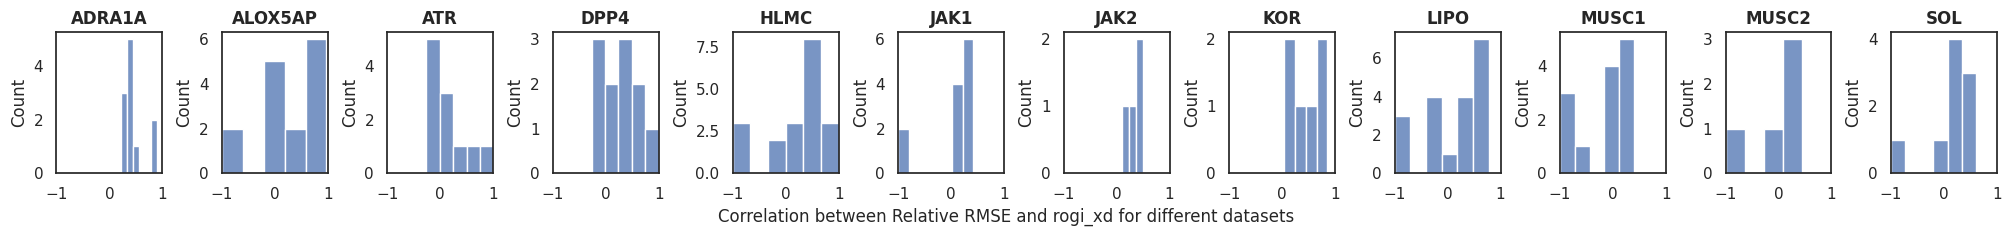

100%|██████████| 12/12 [00:00<00:00, 54.97it/s]


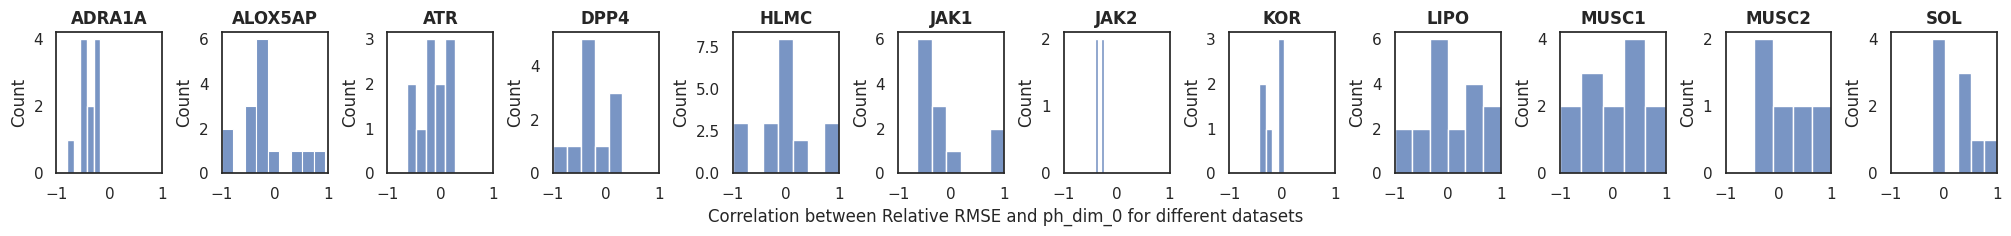

100%|██████████| 12/12 [00:00<00:00, 53.27it/s]


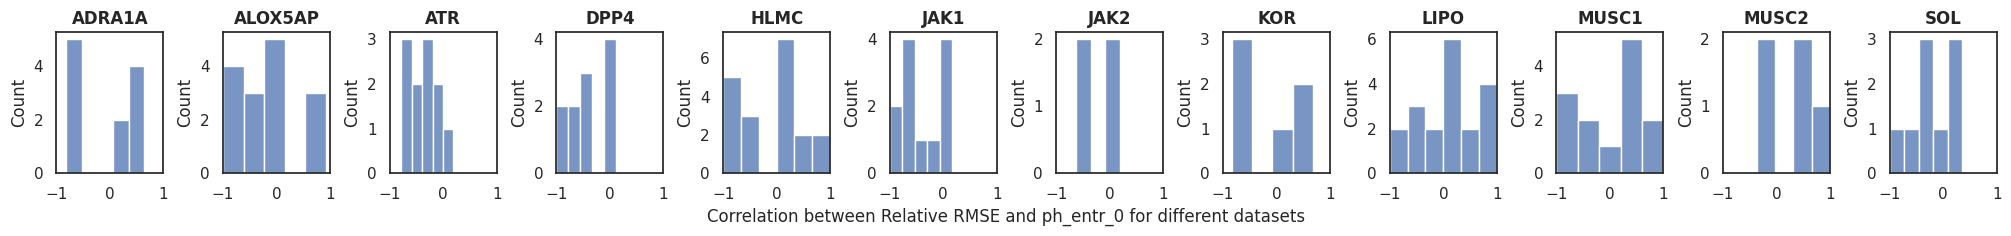

100%|██████████| 12/12 [00:00<00:00, 57.32it/s]


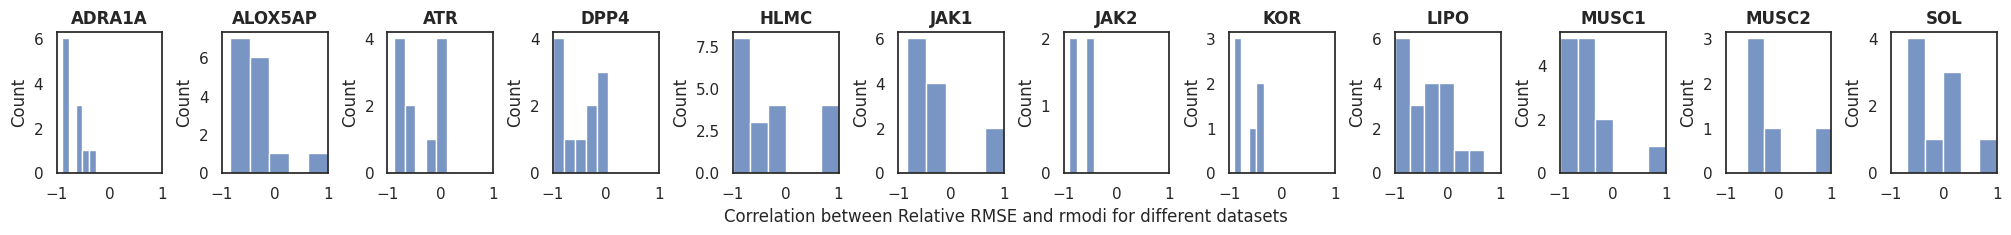

100%|██████████| 12/12 [00:00<00:00, 56.31it/s]


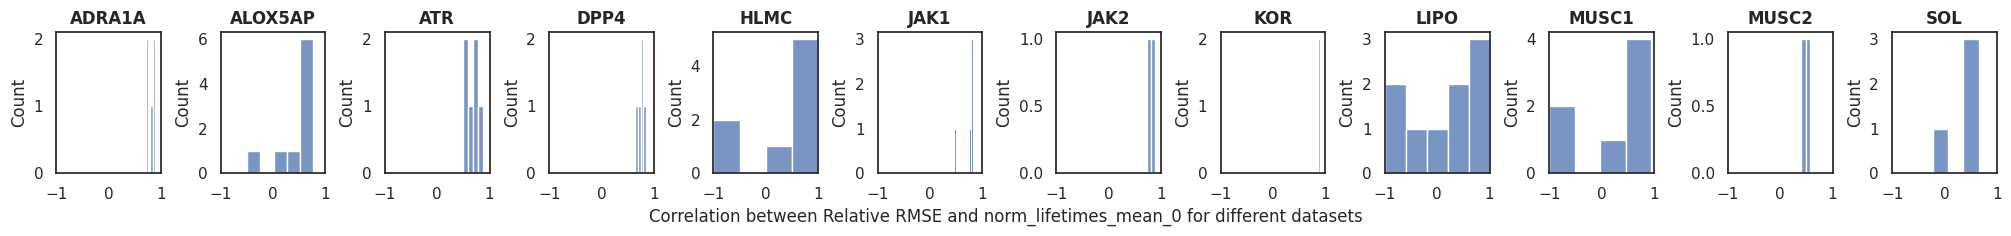

In [8]:
import numpy as np
import scipy as sp
from utils import create_subplots
import seaborn as sns


def plot_correlation_hist(row, ax, legend=False, x=None, y=None, hue=None):
    if not np.isnan(row[x]).all():
        sns.histplot(x=row[x], ax=ax) # palette="tab10", hue=row[hue])
        if not legend:
                ax.legend([],[], frameon=False)


for score in ["rogi_xd", "ph_dim_0", "ph_entr_0", "rmodi", "norm_lifetimes_mean_0"]:
        stat = "Relative RMSE"
        metric = score

        def compute_corr(row):
                if row[stat].shape[0] < 2 or row[metric].shape[0] < 2:
                        return np.nan
                s = np.nan_to_num(row[stat], neginf=0)  
                e = np.nan_to_num(row[metric], neginf=0)
                r, p = sp.stats.pearsonr(s, e)
                return r

        filter = {
               "split": "scaffold", 
        }

        subset = filter_df(df, filter)

        # Aggregate individual pairs
        e = subset.groupby(["dataset", "samples", "model", "distance_metric"])[metric].apply(np.array).reset_index(name=metric)
        h = subset.groupby(["dataset", "samples", "model", "distance_metric"])[stat].apply(np.array).reset_index(name=stat)

        grouped = e.merge(h)
        grouped["R"] = grouped.apply(lambda x: compute_corr(x), axis=1)
        # e = grouped.groupby("dataset")[hue].apply(np.array).reset_index(name=hue)
        plt_data = grouped.groupby("dataset")["R"].apply(np.array).reset_index(name="R")
        # plt_data = plt_data.merge(h)

        create_subplots(plt_data, plot_correlation_hist, 
                        n_cols=plt_data["dataset"].nunique(), 
                        col_labels=plt_data["dataset"].unique(),
                        figsize=(20, 2), kwargs={"x": "R"},
                        x_range=[-1, 1],
                        title=f"Correlation between {stat} and {metric} for different datasets")


#### Plot 2: Correlations scatterplot for individual datasets

100%|██████████| 5/5 [00:00<00:00,  8.06it/s]


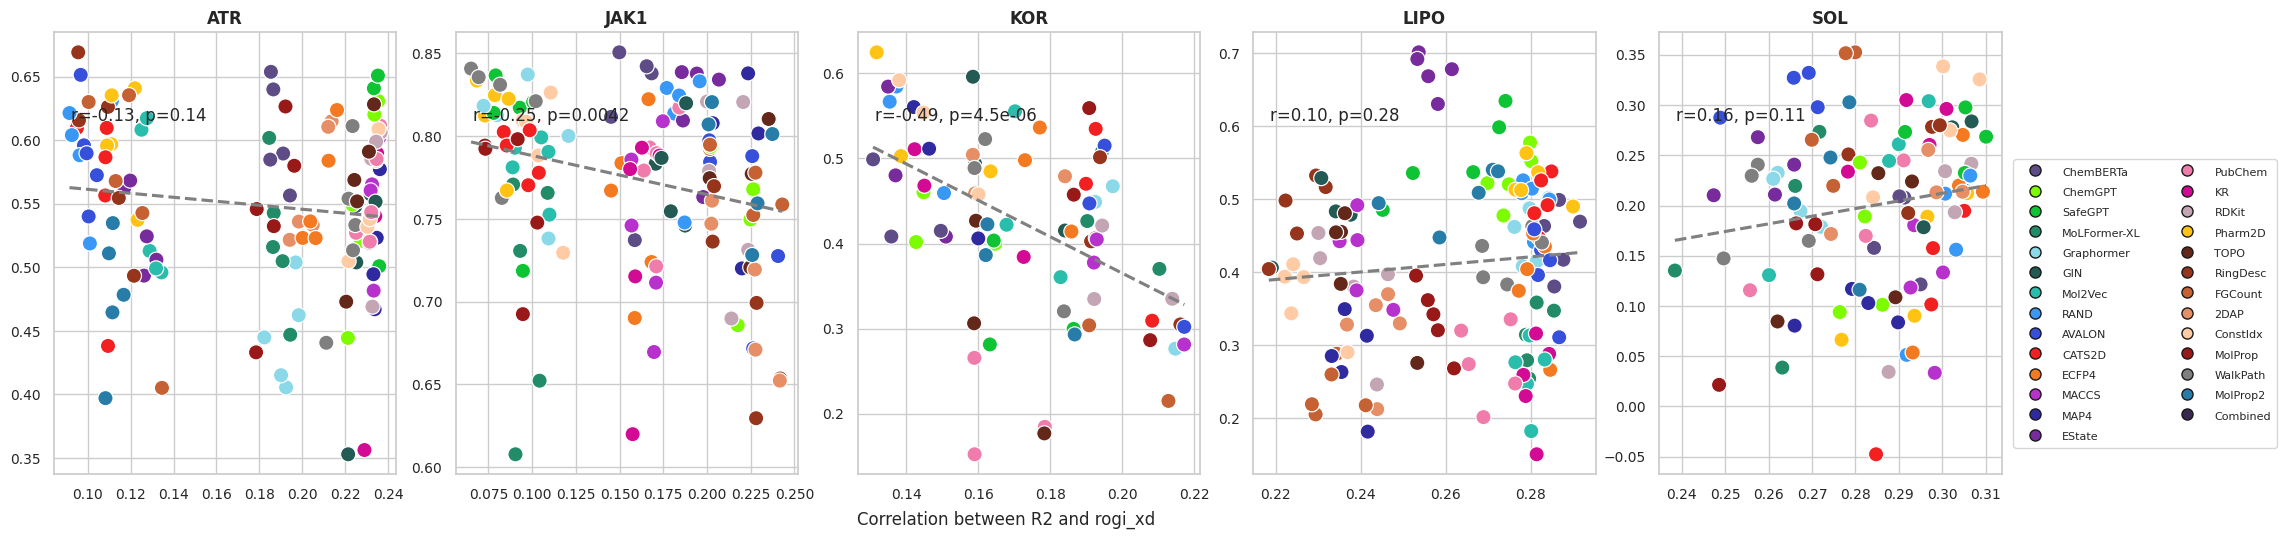

100%|██████████| 5/5 [00:00<00:00, 15.75it/s]


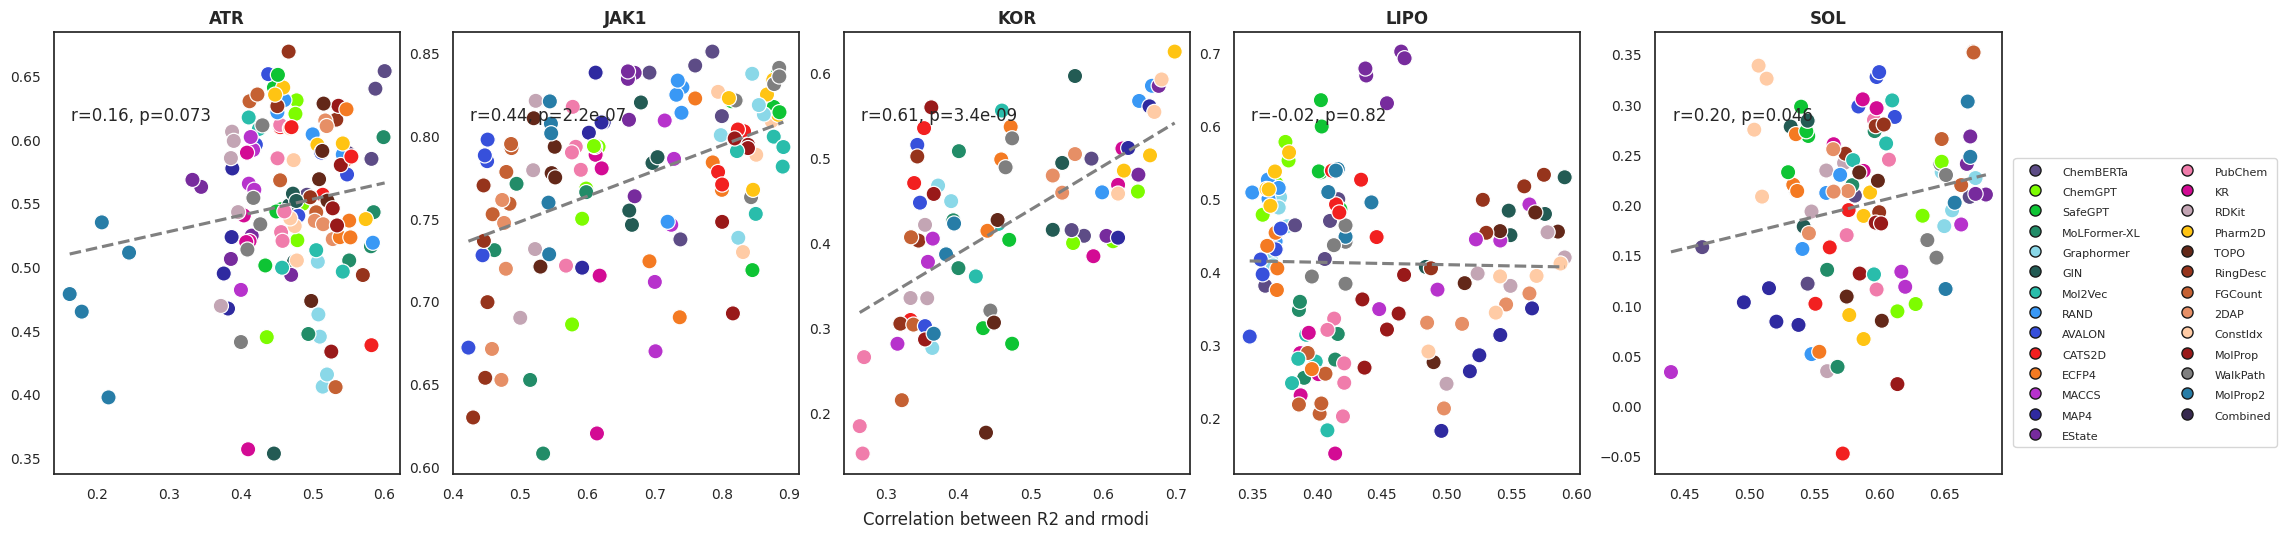

100%|██████████| 5/5 [00:00<00:00, 16.10it/s]


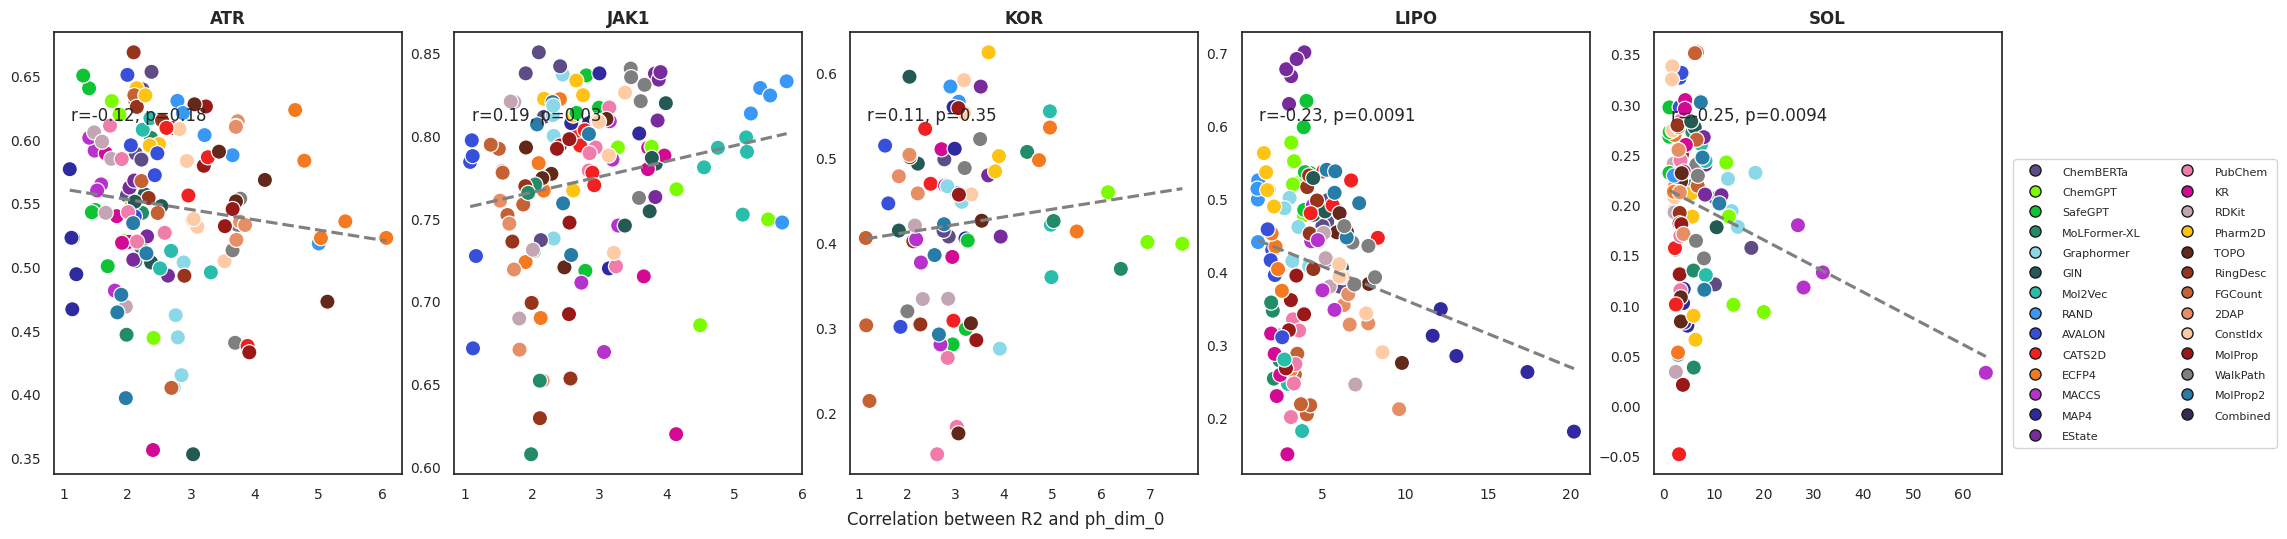

100%|██████████| 5/5 [00:00<00:00,  7.47it/s]


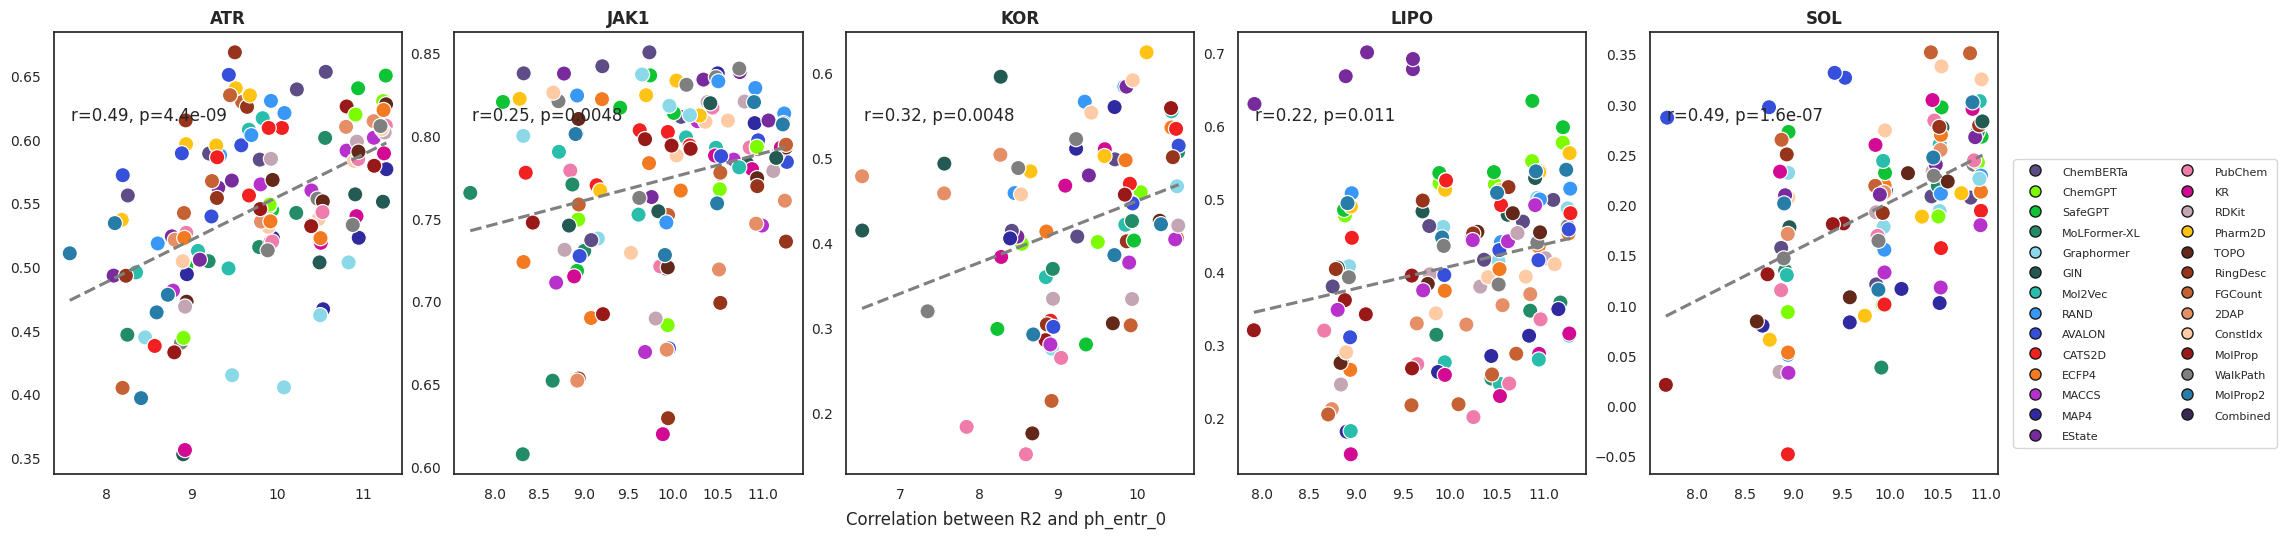

100%|██████████| 5/5 [00:00<00:00, 16.11it/s]


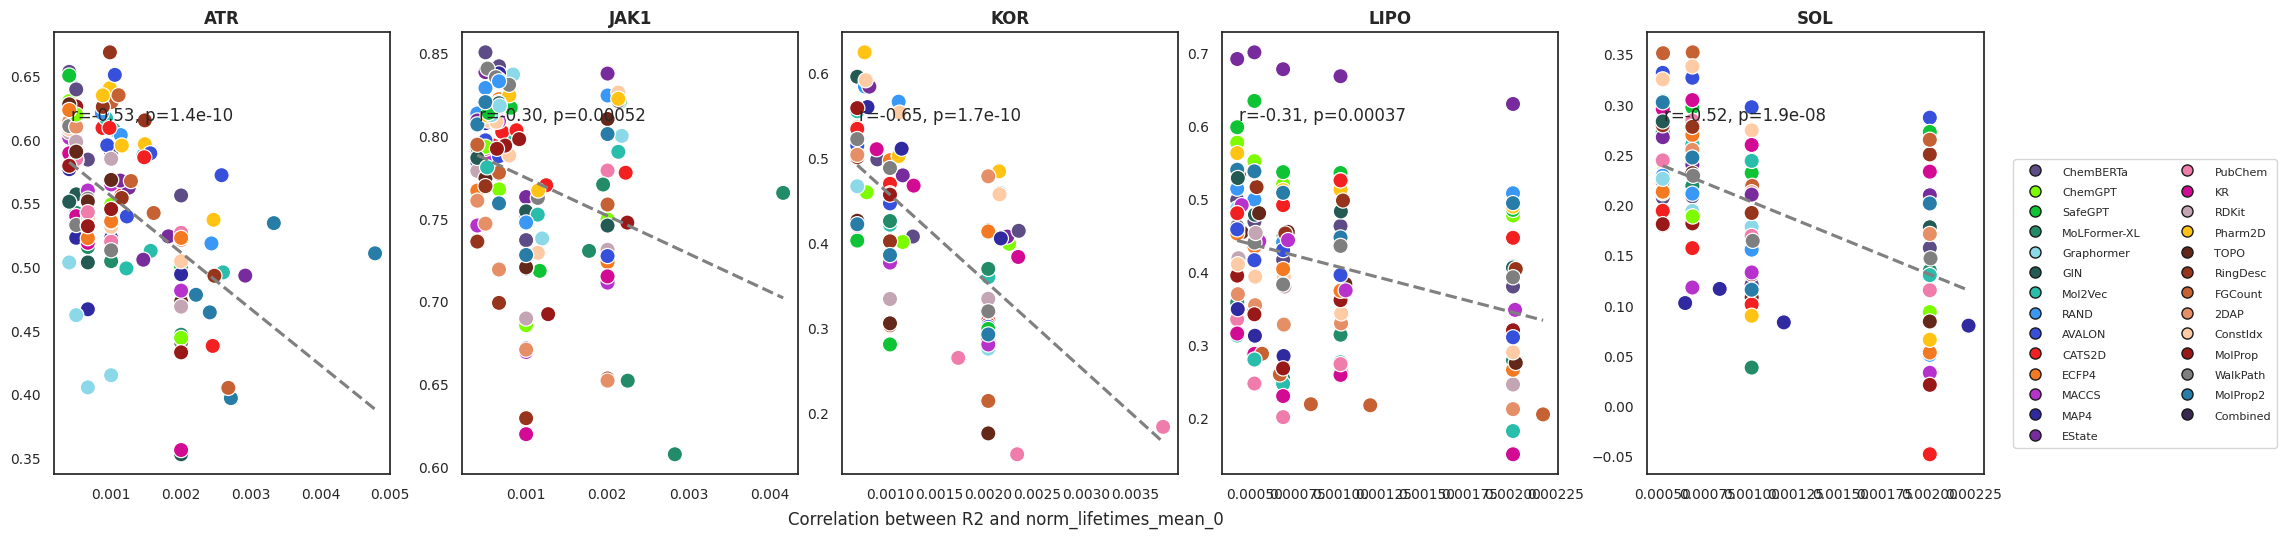

In [7]:
from functools import reduce
from utils import plot_phd_corr
from plotting import get_palettes, load_plot_config
from utils import create_subplots
import warnings
warnings.filterwarnings('ignore')

load_plot_config()
rep, dat = get_palettes()

for metric in ["rogi_xd", "rmodi", f"ph_dim_0", f"ph_entr_0", "norm_lifetimes_mean_0"]:
    hue = "Representation"
    stat = metric
    err = "R2"

    filter = {
                "split": "random",
                "dataset": ["ATR", "JAK1", "KOR", "LIPO", "SOL"],
            }

    subset = filter_df(df, filter)

    s = subset.groupby("dataset")["representation"].apply(np.array).reset_index(name=hue)
    e = subset.groupby("dataset")[stat].apply(np.array).reset_index(name=stat)
    h = subset.groupby("dataset")[err].apply(np.array).reset_index(name=err)
    plt_data = reduce(lambda  left, right: pd.merge(left, right, on=['dataset'],
                                                how='outer'), [s, e, h])
    create_subplots(plt_data, plot_phd_corr, 
                    n_cols=plt_data["dataset"].nunique(),
                    col_labels=plt_data["dataset"].values,
                    figsize=(20, 5), kwargs={"stat": stat, "err": err, "rep": "Representation", "palette": rep,
                                             "alpha": 1.0, "markeredgecolor": "k", "markeredgewidth": 1.0},
                    title=f"Correlation between {err} and {stat}")

#### Plot 3: Impact of representation type on correlation

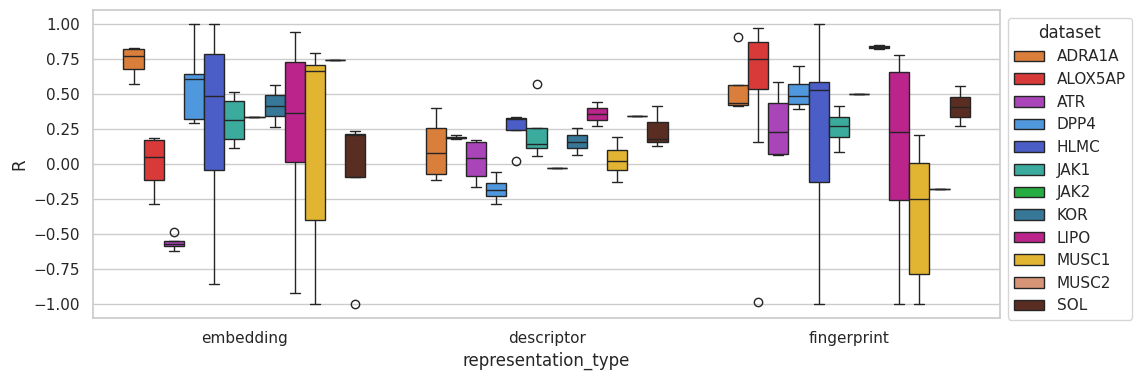

In [44]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 11.7, 4

load_plot_config()
rep, dat = get_palettes()
hue = "dataset"
stat = "Relative RMSE"
metric = "rogi_xd" 
filter = {
    "split": "scaffold",
    "samples": {"gte": 1000}
}

def compute_corr(row):
    if row[stat].shape[0] < 2 or row[metric].shape[0] < 2:
            return np.nan
    s = np.nan_to_num(row[stat], neginf=0)  
    e = np.nan_to_num(row[metric], neginf=0)
    r, p = sp.stats.pearsonr(s, e)
    return r

subset = filter_df(df, filter)


# Aggregate individual pairs
e = subset.groupby(["dataset", "samples", "model", "distance_metric", "representation_type"])[metric].apply(np.array).reset_index(name=metric)
h = subset.groupby(["dataset", "samples", "model", "distance_metric", "representation_type"])[stat].apply(np.array).reset_index(name=stat)

grouped = e.merge(h)

grouped["R"] = grouped.apply(lambda x: compute_corr(x), axis=1)
plot = sns.boxplot(grouped, x="representation_type", y="R", hue=hue, palette=sns.color_palette(dat.values()))
sns.move_legend(plot, "upper left", bbox_to_anchor=(1, 1))

#### Plot 4: Lifetime distribution for different error bins

Plotting 3000 sampled intervals.
Plotting 3000 sampled intervals.
Plotting 3000 sampled intervals.


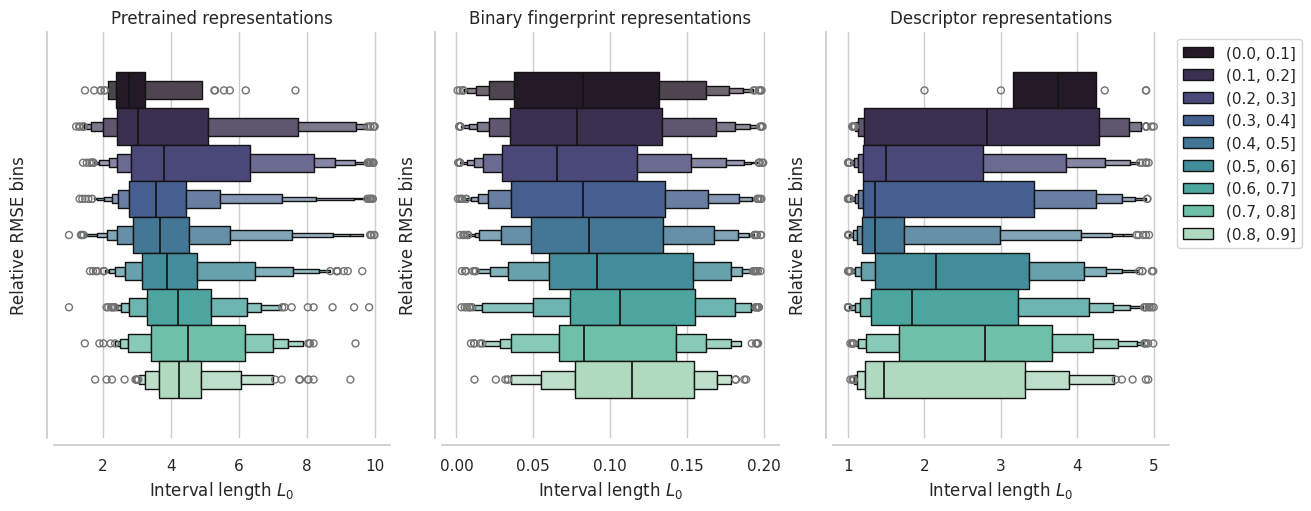

In [47]:
import plotly.express as pex
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

load_plot_config()

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(13, 5), constrained_layout=True)
error_metric = "Relative RMSE"
interval_selector = "intervals_0" # "norm_intervals_0"


def life_dist_plot(axis, representation_type, title, color="bins", max_length=1, legend=False, n_samples=3000):
    filter = {
        "samples": {"gte": 500},
        "split": "scaffold",
        "representation_type": {"all": None},
        "distance_metric": {"all": None}
}

    subset = filter_df(df, filter)
    bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    subset["bins"] = pd.cut(subset[error_metric], bins=bins)
    subset = subset[~subset["bins"].isna()]
    hue_order = subset["bins"].sort_values().unique()
    s1 = subset[subset["representation_type"] == representation_type]
    hue_order = s1[color].sort_values().unique()
    intervals = np.concatenate([row[interval_selector] for i, row in s1.iterrows()])
    hue = np.concatenate([[row[color]]*len(row[interval_selector]) for i, row in s1.iterrows()])
    mask = intervals < max_length

    # Mask length
    intervals = intervals[mask]
    hue = hue[mask]

    if intervals.shape[0] < n_samples:
        print(f"Plotting {intervals.shape[0]} intervals.")
    else:
        print(f"Plotting {n_samples} sampled intervals.")
        rand_idx = np.random.choice(len(intervals), n_samples)
        intervals = intervals[rand_idx]
        hue = hue[rand_idx]    
    p = sns.boxenplot(x=intervals, hue=hue, dodge=True, hue_order=hue_order, ax=axis, palette="mako", linewidth=1, legend=legend)
    axis.set_title(title)
    axis.set(xlabel=r'Interval length $L_{0}$', ylabel=f'{error_metric} bins')
    sns.despine(offset=5)
    if legend:
        sns.move_legend(p, "upper left", bbox_to_anchor=(1, 1))


life_dist_plot(axs[0],  "embedding", "Pretrained representations", max_length=10)
life_dist_plot(axs[1],  "fingerprint", "Binary fingerprint representations", max_length=0.2)
life_dist_plot(axs[2],  "descriptor", "Descriptor representations", max_length=5, legend=True)

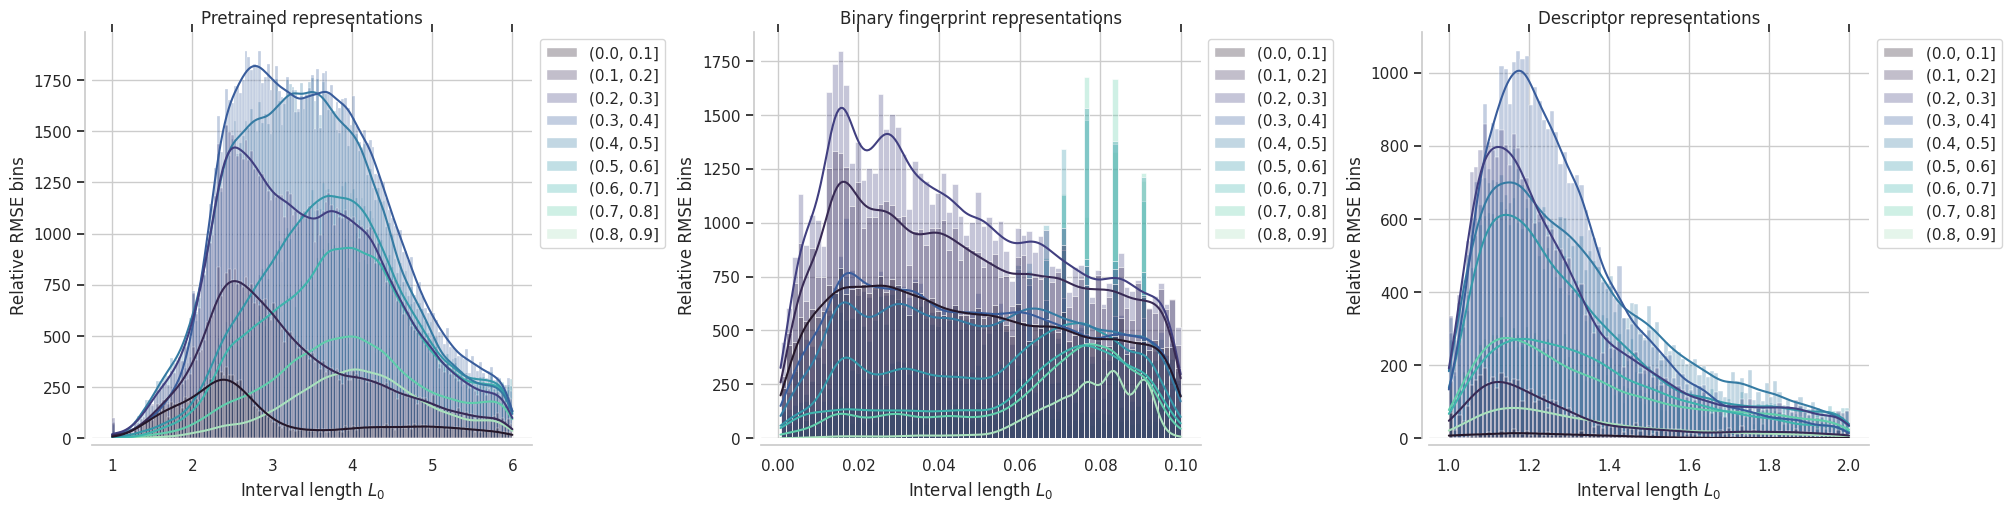

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as pex
import numpy as np


fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 5), constrained_layout=True)
error_metric = "Relative RMSE"
interval_selector = "intervals_0" 


def life_dist_plot(axis, representation_type, title, color="bins", legend=True, max_len=1000):
    filter = {
    }

    subset = filter_df(df, filter)
    bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    subset["bins"] = pd.cut(subset[error_metric], bins=bins)
    subset = subset[~subset["bins"].isna()]
    hue_order = subset["bins"].sort_values().unique()

    s1 = subset[subset["representation_type"] == representation_type]
    hue_order = s1[color].sort_values().unique()
    intervals = np.concatenate([row[interval_selector] for i, row in s1.iterrows()])
    hue = np.concatenate([[row[color]]*len(row[interval_selector]) for i, row in s1.iterrows()])
    mask = intervals < max_len
    p = sns.histplot(x=intervals[mask], hue=hue[mask], hue_order=hue_order, kde=True, alpha=0.3, ax=axis, palette="mako")
    axis.set_title(title)
    axis.set(xlabel=r'Interval length $L_{0}$', ylabel=f'{error_metric} bins')
    sns.despine(offset=5)
    sns.move_legend(p, "upper left", bbox_to_anchor=(1, 1))

# color = dimensionality, samples, representation, 
life_dist_plot(axs[0], "embedding", "Pretrained representations", max_len=6, color="bins")
life_dist_plot(axs[1], "fingerprint",  "Binary fingerprint representations", max_len=0.1, color="bins")
life_dist_plot(axs[2], "descriptor",  "Descriptor representations", max_len=2, color="bins")